- 6) Population structure with Admixture

    - to infer how many populations exist
        (how many ancestral populations generate the current population)
    - to identify potential migrants and admixed individuals

- We will use a 10 percent subsampling of autosomes LD-pruned with no offspring
    (hapmap10_auto_noofs_ld.bed - binary form )

# 1) [fastStructure](http://rajanil.github.io/fastStructure)
   - SNP genotype data로부터 population structure를 추론

fastStructure is an algorithm for inferring population structure from large SNP genotype data. It is based on a variational **Bayesian framework** for posterior inference and is written in Python2.x. Here, we summarize how to setup this software package, compile the C and Cython scripts and run the algorithm on a test simulated genotype dataset.

# 2) [Admixture](http://www.genetics.ucla.edu/software/admixture)
    
   - SNP genotype data로부터 ancestries를 추론

admixture is a software tool for **maximum likelihood estimation** of individual ancestries from multilocus SNP genotype datasets. It uses the same statistical model as STRUCTURE but calculates estimates much more rapidly using a fast numerical optimization algorithm. 


In [3]:
from collections import defaultdict
import os

import matplotlib.pyplot as plt

from genomics.popgen.admix import cluster, plot

%matplotlib inline

i)  **K** number of ancestral populations 정함

In [4]:
k_range = range(2, 10)  # 2..9

ii) admixture 설치 및 수행 (굉장히 오래 걸림)

hapmap10_auto_noofs_ld.bed 을 input으로 아래 output들 생성됨.
- admix.2, hapmap10_auto_noofs_ld.2.Q, hapmap10_auto_noofs_ld.2.P
- admix.3, hapmap10_auto_noofs_ld.3.Q, hapmap10_auto_noofs_ld.3.P
- admix.4, hapmap10_auto_noofs_ld.4.Q, hapmap10_auto_noofs_ld.4.P
- admix.5, hapmap10_auto_noofs_ld.5.Q, hapmap10_auto_noofs_ld.5.P
- admix.6, hapmap10_auto_noofs_ld.6.Q, hapmap10_auto_noofs_ld.6.P
- admix.7, hapmap10_auto_noofs_ld.7.Q, hapmap10_auto_noofs_ld.7.P
- admix.8, hapmap10_auto_noofs_ld.8.Q, hapmap10_auto_noofs_ld.8.P
- admix.9, hapmap10_auto_noofs_ld.9.Q, hapmap10_auto_noofs_ld.9.P

In [16]:
for k in k_range:
    os.system('admixture --cv=10 hapmap10_auto_noofs_ld.bed %d -j4 > admix.%d' % (k, k))

iii) **ind_order**

In [5]:
f = open('hapmap10_auto_noofs_ld.fam')
ind_order = []
for l in f:
    toks = l.rstrip().replace(' ', '\t').split('\t')
    fam_id = toks[0]
    ind_id = toks[1]
    ind_order.append((fam_id, ind_id))
f.close()

각 admix.2~9 파일을 연 후에 'CV(cross-validation) error' 값을 저장하여 plot

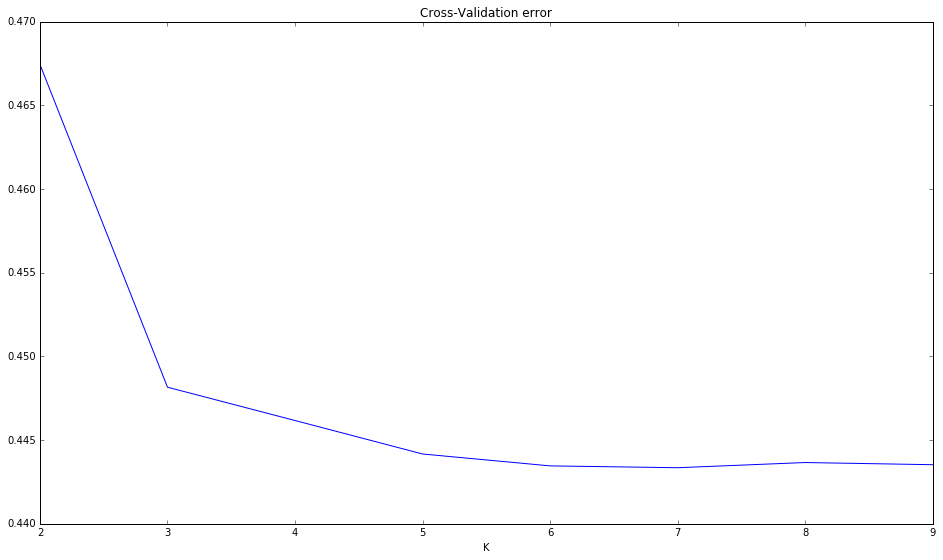

In [12]:
CVs = []
for k in k_range:
    f = open('admix.%d' % k)
    for l in f:
        if l.find('CV error') > -1:
            CVs.append(float(l.strip().split(' ')[-1].split('<')[0]))
            break
    f.close()
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.plot(k_range, CVs)
ax.set_title('Cross-Validation error')
ax.set_xlabel('K')

iv) pop_ind

In [13]:
f = open('relationships_w_pops_121708.txt')
pop_ind = defaultdict(list)
f.readline()  # header
for l in f:
    toks = l.rstrip().split('\t')
    fam_id = toks[0]
    ind_id = toks[1]
    if (fam_id, ind_id) not in ind_order:
        continue
    mom = toks[2]
    dad = toks[3]
    if mom != '0' or dad != '0':
        continue
    pop = toks[-1]
    pop_ind[pop].append((fam_id, ind_id))
#ind_pop[('2469', 'NA20281')] = ind_pop[('2805', 'NA20281')]
f.close()

v) load Q files

- 각 개인당 추정 ancestor에 따른 ancestral component를 계산.

In [18]:
def load_Q(fname, ind_order):
    ind_comps = {}
    f = open(fname)
    for i, l in enumerate(f):
        comps = [float(x) for x in l.rstrip().split(' ')]
        ind_comps[ind_order[i]] = comps
    f.close()
    return ind_comps

vi-1) **comps** dictionary {('fam_id','ind_id'):[component1, component2,..], }

In [21]:
comps = {}
for k in k_range:
    comps[k] = load_Q('hapmap10_auto_noofs_ld.%d.Q' % k, ind_order)
#{('Y050', 'NA19210'): [0.99999, 1e-05], ('NA19001', 'NA19001'): [1e-05, 0.99999], ..

vi-2) **cluster** list of tuple ('pop',[('fam_id','ind_id'), ('fam_id','ind_id'),...])

In [22]:
ordering = {}
for k in k_range:
    ordering[k] = cluster(comps[k], pop_ind)
# OrderedDict([('MEX', [('M027', 'NA19759'), ('M017', 'NA19726'), ... 

vii) plot

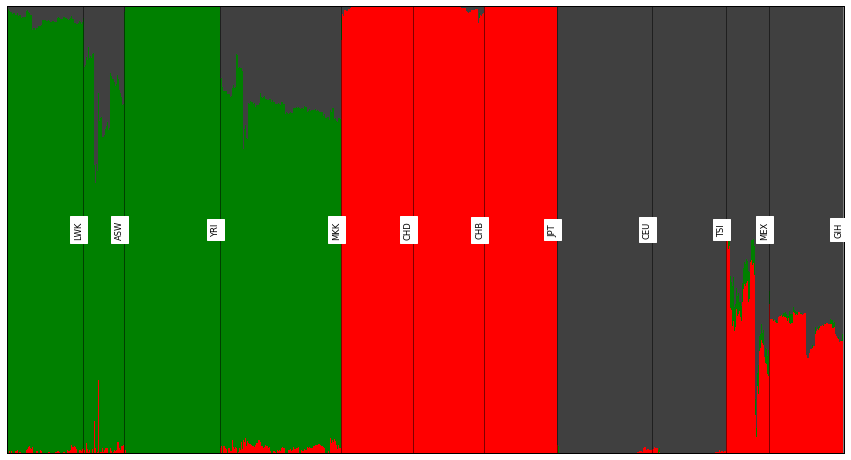

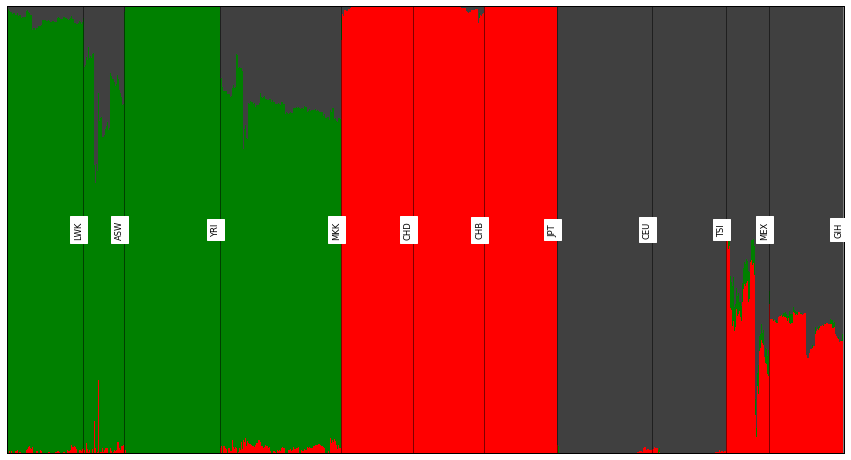

In [46]:
plot.single(comps[3], ordering[3])

- K 2~9 까지 stacked individual plot of admixture
- require a figure object

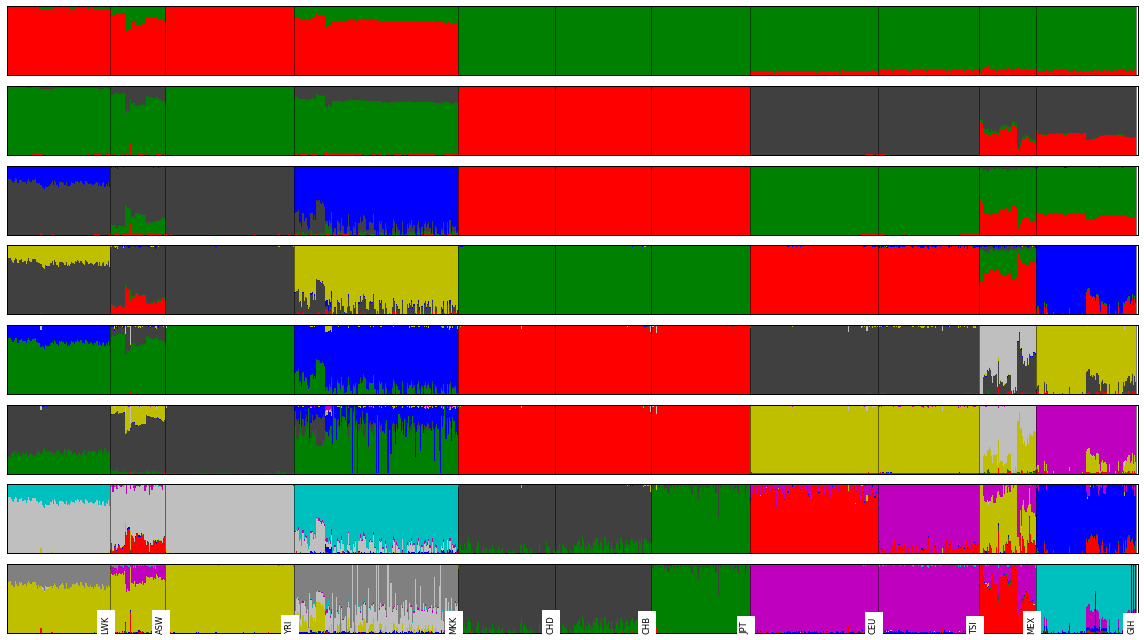

In [40]:
fig = plt.figure(figsize=(16, 9))
plot.stacked(comps, ordering[3], fig)

The best practice is to actually run 100 instances and get the one with the best log likelihood(for publishable results).
